<a href="https://colab.research.google.com/github/Sandwhaletree/2023.05_Tibame/blob/main/A12_%E9%80%B2%E9%9A%8E%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92_%E6%9D%8E%E6%99%BA%E6%8F%9A/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from tqdm.auto import tqdm

In [2]:
BS = 128
EPOCHS = 10
LOG_INTERVAL = 100 # how many batches to wait before logging training status
device = "cuda" if torch.cuda.is_available() else "cpu"
use_mps = False
kwargs = {'num_workers': 1, 'pin_memory': True}

os.makedirs("results", exist_ok=True) # image dir

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()), # 0~1 #原始檔近來有經過ToTensor()轉換
    batch_size=BS, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=BS, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 95588873.13it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83426786.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26402679.24it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18212742.61it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



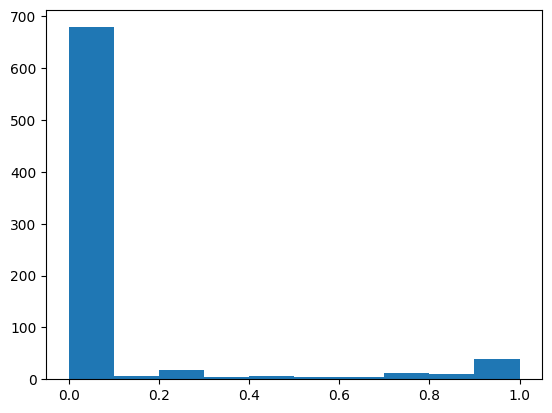

In [11]:
import matplotlib.pyplot as plt
img, label=test_loader.dataset[0]
plt.hist(img.view(-1))
plt.show()

In [4]:
# 28*28 = 784 #單通道
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128), #壓縮變1258
            nn.Linear(128, 64),
            nn.Linear(64, 32), #經過encoder輸出為32(壓縮長度為32的向量)
        )
        # decoder #壓縮長度為32的向量還原成原圖784
        self.decoder = nn.Sequential
            nn.Linear(32, 64), #將
            nn.Linear(64, 128),
            nn.Linear(128, 784),
            nn.Sigmoid(), #因數值未指定，故用Sigmoid
        )

    def forward(self, x):
        z = self.encoder(x.view(-1, 784)) #一定要784
        output = self.decoder(z)
        return output

In [5]:
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss() #損失函數，與ppt上有取平均相比，這邊沒有取平均

def train(epoch): #epoch與之前很相近
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, leave=False)): #但沒有用到正確答案(即類別)，僅需要圖片本身就好
        data = data.to(device)
        optimizer.zero_grad()
        img_recon = model(data) #重建 reconstruction
        loss = loss_func(img_recon, data.view(-1, 784)) #重建後影像、與原始影像去看誤差
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            img_recon = model(data)
            test_loss += loss_func(img_recon, data.view(-1, 784)).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      img_recon.view(BS, 1, 28, 28)[:n]])
                save_image(comparison.cpu(), #重建後結果影響儲存，去看與原圖相比有沒有更好
                         'results/AE_reconstruct_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [6]:
# training
for epoch in tqdm(range(1, EPOCHS + 1)):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device) #一批的隨機向量
        sample = model.decoder(sample).cpu() #丟到decoder，前面encoder就不需要了
        save_image(sample.view(64, 1, 28, 28), #一維向量
                   'results/AE_sample_' + str(epoch) + '.png') #重建後的誤差會越來越小

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001810
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.000433
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000348
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000297
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000259
====> Epoch: 1 Average loss: 0.0004
====> Test set loss: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000228
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000233
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000193
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000180
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000175
====> Epoch: 2 Average loss: 0.0002
====> Test set loss: 0.0002


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000180
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000159
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000163
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000153
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000154
====> Epoch: 3 Average loss: 0.0002
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000147
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000157
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000147
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000150
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000136
====> Epoch: 4 Average loss: 0.0001
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000128
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000129
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000125
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000127
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000117
====> Epoch: 5 Average loss: 0.0001
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000112
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000116
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000108
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000118
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000111
====> Epoch: 6 Average loss: 0.0001
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000123
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000111
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000112
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000112
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000097
====> Epoch: 7 Average loss: 0.0001
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000104
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000096
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000097
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000095
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000107
====> Epoch: 8 Average loss: 0.0001
====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000100
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000099
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000089
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000099
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000087
====> Epoch: 9 Average loss: 0.0001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7821e03c11b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7821e03c11b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

====> Test set loss: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7821e03c11b0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7821e03c11b0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000099
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000099
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000099
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000093
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000098
====> Epoch: 10 Average loss: 0.0001
====> Test set loss: 0.0001


In [7]:
torch.save(model.state_dict(), "ae.pt")

#### Reconstruct

In [8]:
import matplotlib.pyplot as plt

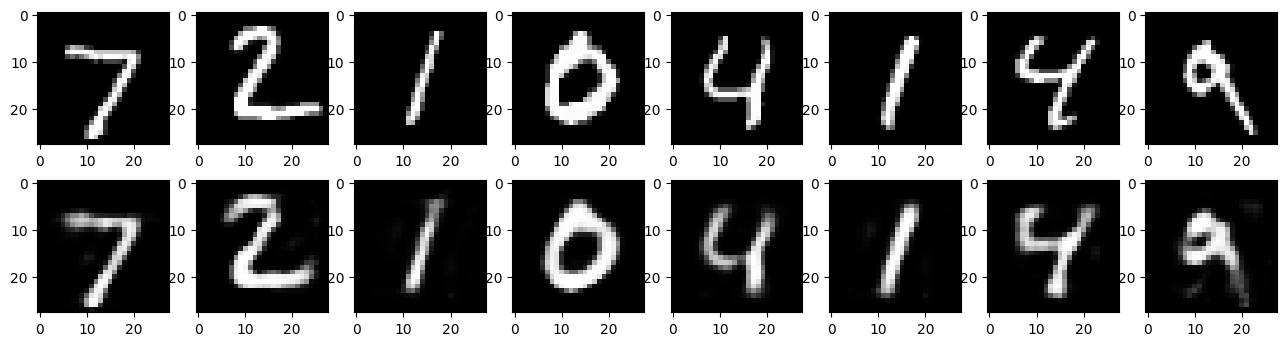

In [9]:
for i, (data, _) in enumerate(test_loader):
    data = data.to(device)
    img_recon = model(data).view(BS, 1, 28, 28)
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                          img_recon[:n]]).squeeze(1).detach().cpu()
    # show image
    plt.figure(figsize=(16, 4))
    for i in range(len(comparison)):
        plt.subplot(2, 8, i+1)
        plt.imshow(comparison[i], cmap="gray")
    plt.show()
    break

#### Generative

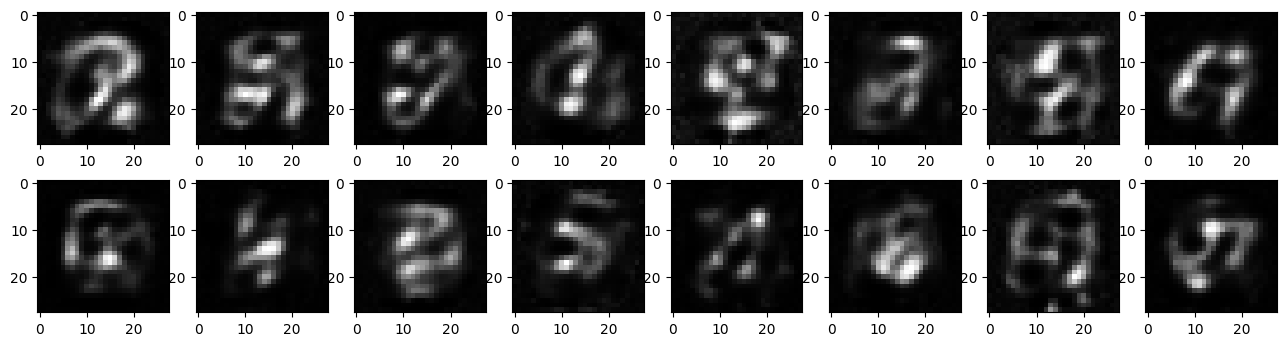

In [10]:
with torch.no_grad():
    sample = torch.randn(16, 32).to(device)
    sample = model.decoder(sample).reshape(16, 28, 28).cpu()

# show image
plt.figure(figsize=(16, 4))
for i in range(len(sample)):
    plt.subplot(2, 8, i+1)
    plt.imshow(sample[i], cmap="gray")
plt.show()